In [37]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

In [38]:
# Get the data
qqq = yf.download(tickers="QQQ", period="24h", interval="1m")
btc = yf.download(tickers="BTC-USD", period="24h", interval="1m")

# Print the data
print(qqq.tail())
print(btc.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                                 Open        High         Low       Close  \
Datetime                                                                    
2022-04-18 15:56:00-04:00  338.059998  338.410004  338.035004  338.299988   
2022-04-18 15:57:00-04:00  338.290009  338.429993  338.190002  338.290009   
2022-04-18 15:58:00-04:00  338.279999  338.420013  338.200012  338.410004   
2022-04-18 15:59:00-04:00  338.410004  338.950012  338.369995  338.950012   
2022-04-18 16:00:00-04:00  338.690002  338.690002  338.690002  338.690002   

                            Adj Close  Volume  
Datetime                                       
2022-04-18 15:56:00-04:00  338.299988  395669  
2022-04-18 15:57:00-04:00  338.290009  214414  
2022-04-18 15:58:00-04:00  338.410004  434876  
2022-04-18 15:59:00-04:00  338.950012  717944  
2022-04-18 16:00:00-04:00  338.690

In [39]:
df = qqq.merge(btc,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_qqq","_btc"])
print(df.tail())

                             Open_qqq    High_qqq     Low_qqq   Close_qqq  \
Datetime                                                                    
2022-04-18 15:54:00-04:00  337.589996  337.605011  337.489990  337.570007   
2022-04-18 15:55:00-04:00  337.855011  338.070007  337.839996  338.065002   
2022-04-18 15:56:00-04:00  338.059998  338.410004  338.035004  338.299988   
2022-04-18 15:57:00-04:00  338.290009  338.429993  338.190002  338.290009   
2022-04-18 15:58:00-04:00  338.279999  338.420013  338.200012  338.410004   

                           Adj Close_qqq  Volume_qqq      Open_btc  \
Datetime                                                             
2022-04-18 15:54:00-04:00     337.570007       25354  40482.136719   
2022-04-18 15:55:00-04:00     338.065002      560884  40504.167969   
2022-04-18 15:56:00-04:00     338.299988      395669  40510.152344   
2022-04-18 15:57:00-04:00     338.290009      214414  40543.585938   
2022-04-18 15:58:00-04:00     338.410004

In [40]:
y1 = df['Close_qqq']
y2 = df['Close_btc']
y1 = (y1 - np.mean(y1)) / np.std(y1)
y2 = (y2 - np.mean(y2)) / np.std(y2)

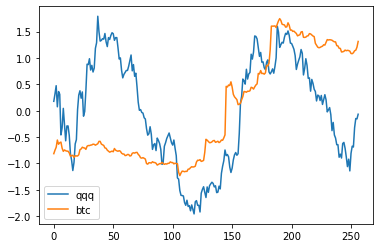

In [43]:
plt.plot(range(len(y1)),y1, label="qqq")
plt.plot(range(len(y2)),y2, label="btc")
plt.legend()

In [42]:
def max_offset(df1, df2):
    print(len(df1), len(df2))
    corrs = signal.correlate(df1, df2, mode='full')
    return np.argmax(corrs) - len(df1) + 1, corrs[np.argmax(corrs)]
print(max_offset(y1,y2))

257 257
(6, 99.04064460017995)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


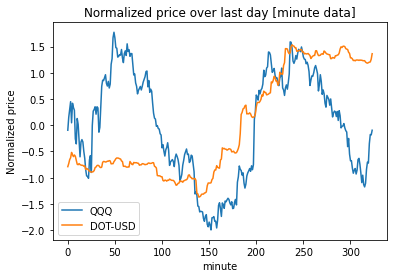

324 324
(7, 119.05203305017503)


In [45]:
def ticker_offset(str1, str2):
    a = yf.download(tickers=str1, period="24h", interval="1m")
    b = yf.download(tickers=str2, period="24h", interval="1m")
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    plt.plot(range(len(y1)),y1, label=str1)
    plt.plot(range(len(y2)),y2, label=str2)
    plt.legend()
    plt.title("Normalized price over last day [minute data]")
    plt.ylabel("Normalized price")
    plt.xlabel("minute")
    plt.show()
    return max_offset(y1,y2)
print(ticker_offset("QQQ","DOT-USD"))